In [1]:
import random
import numpy as np
import scipy as sp
import math
from sklearn import metrics
from sklearn import svm
from sklearn import manifold
from sklearn.datasets import *
from sklearn.neighbors import NearestNeighbors
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import seaborn as sns
%matplotlib inline

In [2]:
#%run 'Flow-functions.ipynb'
%run 'Theano-functions.ipynb'

/opt/conda/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using gpu device 0: Tesla K40c (CNMeM is disabled)

Overwriting /cluster/thashim/.theanorc
[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.270680 seconds


/opt/conda/envs/python2/lib/python2.7/site-packages/theano/gradient.py:545: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: b
  handle_disconnected(elem)



Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


/opt/conda/envs/python2/lib/python2.7/site-packages/theano/gradient.py:571: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: <DisconnectedType>
  handle_disconnected(rval[i])


## Basic test

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


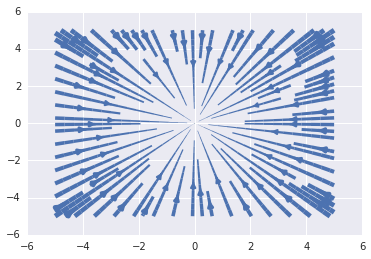

In [3]:
x_test = np.linspace(-5,5,50)
y_test = np.linspace(-5,5,50)
def quadratic_flow(v):
    return -v
plot_flow(x_test,y_test,quadratic_flow)

In [4]:
def styblinski_tang(v):
    return -1*(3*v**3-32*v+5)/2.0

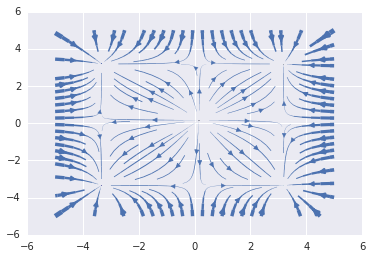

In [5]:
plot_flow(x_test,y_test,styblinski_tang)

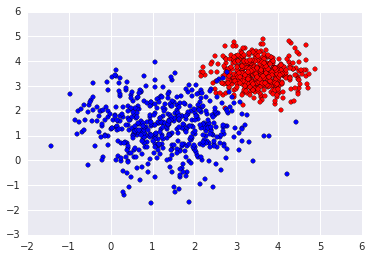

In [6]:
np.random.seed(0)

dimseq = [2, 10, 50]
quad_dat_seq = []

for dim in dimseq:
    q_init = np.random.normal(scale=0.5,size=(dim,500))+5.0/np.sqrt(dim)
    q_out = euler_maruyama_dist(q_init,quadratic_flow,0.01,1,1.5)
    quad_dat_seq.append([q_init,q_out])
plt.subplot(111)
plt.scatter(quad_dat_seq[0][0][0,:],quad_dat_seq[0][0][1,:],c='red')
plt.scatter(quad_dat_seq[0][1][0,:],quad_dat_seq[0][1][1,:])

In [7]:
ou_pack

{'backprop': <theano.compile.function_module.Function at 0x7f1ab92d9790>,
 'drift': <theano.compile.function_module.Function at 0x7f1abd932ed0>,
 'name': 'Orstein-Uhlenbeck potential',
 'potential': <theano.compile.function_module.Function at 0x7f1abd8a6e90>,
 'potential_grad': (<theano.compile.function_module.Function at 0x7f1ab849b550>,
  <theano.compile.function_module.Function at 0x7f1ab8514710>),
 'simulate': <theano.compile.function_module.Function at 0x7f1aba7685d0>,
 'trajectory': <theano.compile.function_module.Function at 0x7f1abd982a50>}

In [8]:
pack_list = {'relu':relu_pack,'orstein-uhlenbeck':ou_pack,'linear':lin_pack,'local':local_pack}
eps_base=0.05
eps_list = {'relu':eps_base,'orstein-uhlenbeck':0.001,'linear':eps_base,'local':eps_base}
tau_list = {'relu':0.7,'orstein-uhlenbeck':0.0,'linear':0,'local':0.7}

In [9]:
def fit_multipack(pack_seq, dat_seq, time_in, sdin,eps_list,tau_list,dtin=0.01,debug=False):
    out_list = []
    for i in xrange(len(dat_seq)):
        print(i)
        tmp_dict = {}
        for name, pack in pack_seq.iteritems():
            print(name)
            tmp_out=run_all(dat_seq[i],time_in,pack, sdin=sdin,tau=tau_list[name], eps_base=eps_list[name],debug=debug, Knum=300)
            tmp_dict[name]=tmp_out
        out_list.append(tmp_dict)
    return out_list

-inf
-inf
-27978.21549
-19563.6982899
-25562.4611694
(-inf, 0.0002)
(-inf, 0.0001)
(-inf, 5e-05)
(-inf, 2.5e-05)
(-inf, 1.25e-05)
(-inf, 6.25e-06)
(-13871.075526667653, 3.125e-06)
(-21623.802959912351, 1.5625e-06)
(-29181.41490191151, 7.8125e-07)
(-24671.995229454871, 3.90625e-07)
-23739.3107737


(<__main__.parset instance at 0x7f1ab0302050>,
 <__main__.parset instance at 0x7f1ab03020e0>)

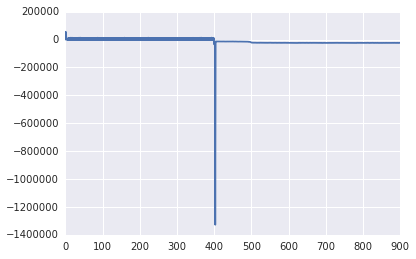

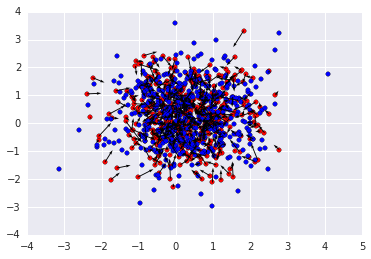

In [10]:
run_all(quad_dat_seq[2],[0,1.0],ou_pack,sdin=1.5,tau=0.7,eps_base=0.002)

In [11]:
quad_fitted = fit_multipack(pack_list, quad_dat_seq, [0,1.0],1.5,eps_list,tau_list)

0
orstein-uhlenbeck
local
linear
relu
1
orstein-uhlenbeck
local
linear
relu
2
orstein-uhlenbeck
local
linear
relu


In [12]:
from sklearn.lda import LDA
def ld_wass(p_pred,p_true,sd):
    if np.all(np.isfinite(p_pred)):
        pp=p_samp(p_true,p_pred.shape[1])
        X = np.hstack([pp,p_pred]).T
        y = np.hstack([np.full(p_pred.shape[1],1),np.full(p_pred.shape[1],0)])
        lda = LDA(n_components=2)
        X_r2 = lda.fit(X, y).transform(X)
        errs = np.sum((np.sort(X_r2[y==0])-np.sort(X_r2[y==1]))**2.0)
    else:
        errs = float('Inf')
    return None, errs

In [13]:
def eval_multipack(params, dat_test, flow_fun, time_in, sdin, dtin=0.01, lossfun=ld_wass):
    pred_list = []
    error_list = []
    for i in xrange(len(dat_test)):
        true_pred = euler_maruyama_dist(dat_test[i][0],flow_fun,dtin,time_in[1],sdin)
        tmp_dict = {'oracle':true_pred}
        for name, paramin in params[i].iteritems():
            simout = paramin[0].simulate(dat_test[i][0],dat_test[i][0].shape[1],time_in[1],dtin,sdin)
            tmp_dict[name]=simout
        tmp_err_dict = {}
        for name, predin in tmp_dict.iteritems():
            delt, err = lossfun(predin, dat_test[i][1], None)
            tmp_err_dict[name] = err
        error_list.append(tmp_err_dict)
        pred_list.append(tmp_dict)
    return pred_list, error_list

In [14]:
np.random.seed(100)
sim_num=500

quad_err_reps = []
for i in xrange(5):
    quad_dat_test = []
    for j in xrange(len(dimseq)):
        dim = dimseq[j]
        q_init = np.random.normal(scale=0.5,size=(dim,sim_num))+5.0/np.sqrt(dim)
        q_out = euler_maruyama_dist(q_init,quadratic_flow,0.01,1,1.5)
        quad_dat_test.append([q_init,q_out])
    quad_predlist, quad_errlist = eval_multipack(quad_fitted, quad_dat_test, quadratic_flow, [0,1.0],1.5)
    quad_err_reps.append(quad_errlist)

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(500, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(500, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [15]:
rep_mat=[]
for rep in quad_err_reps:
    for j in xrange(len(rep)):
        for name, pack in rep[j].iteritems():
            rep_mat.append([name, pack, dimseq[j]])
rep_mat=np.array(rep_mat)

In [16]:
rep_mat[rep_mat[:,0]=='relu',0]='RNN'

In [20]:
import pandas as pd
rep_pd_mat = pd.DataFrame({'dim':rep_mat[:,2].astype(np.float),'Method':rep_mat[:,0],'error':rep_mat[:,1].astype(np.float)})

(800, 5000)

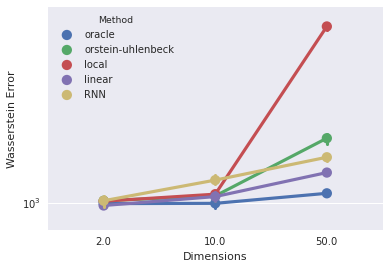

In [21]:
ax = sns.pointplot(data=rep_pd_mat, x="dim", y="error", hue="Method", n_boot=500)
ax.set(yscale='log',ylabel='Wasserstein Error',xlabel='Dimensions')
plt.ylim((800,5000))

## styblinski

In [23]:
np.random.seed(0)
h_init = np.random.normal(scale=0.5,size=(2,300))
h_out = euler_maruyama_dist(h_init,styblinski_tang,0.01,1,2)

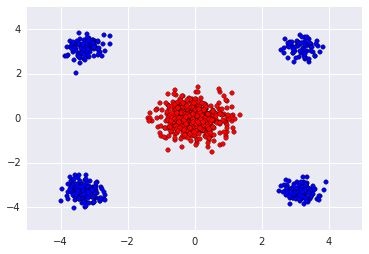

In [25]:
np.random.seed(0)

dat_seq = []

for dim in dimseq:
    q_hidden = np.random.normal(scale=0.5,size=(2,500))
    q_hidden_out = euler_maruyama_dist(q_hidden,styblinski_tang,0.01,1,2)
    q_init = np.vstack([q_hidden,np.zeros((dim-2,500))])
    q_out = np.vstack([q_hidden_out,np.zeros((dim-2,500))])
    dat_seq.append([q_init,q_out])
plt.subplot(111)
plt.scatter(dat_seq[0][0][0,:],dat_seq[0][0][1,:],c='red')
plt.scatter(dat_seq[0][1][0,:],dat_seq[0][1][1,:])

In [26]:
styb_fitted = fit_multipack(pack_list, dat_seq, [0,1.0],2.0,eps_list,tau_list)

0
orstein-uhlenbeck
local
linear
relu
1
orstein-uhlenbeck
local
linear
relu
2
orstein-uhlenbeck
local
linear
relu


In [27]:
def styb_two(v):
    v_sub = v[0:2,]
    v_sub_2 = v[2:,]
    return np.vstack([styblinski_tang(v_sub),-v_sub_2/0.01])

In [28]:
def sinkhorn_two(v1,v2,sd):
    delt, s1=wasserstein_error(v1[0:2,],v2[0:2,],1000)
    s2=np.sum(v1[2:,]**2)
    return None, s1-s2

In [29]:
np.random.seed(100)

styb_test_mean = np.zeros((len(dimseq),len(styb_fitted)))
n_s = 1000
dtt = 0.01

s_err_reps=[]
for j in xrange(10):
    dat_test=[]
    for i in xrange(len(dimseq)):
        dim = dimseq[i]
        q_hidden = np.random.normal(scale=0.5,size=(2,n_s))
        q_hidden_out = euler_maruyama_dist(q_hidden,styblinski_tang,dtt,1,2)
        q_init = np.vstack([q_hidden,np.zeros((dim-2,n_s))])
        q_out = np.vstack([q_hidden_out,np.zeros((dim-2,n_s))])
        dat_test.append([q_init,q_out])
    styb_predlist, styb_errlist = eval_multipack(styb_fitted, dat_test, styb_two, [0,1.0],2,dtin=dtt,lossfun=sinkhorn_two)
    s_err_reps.append(styb_errlist)

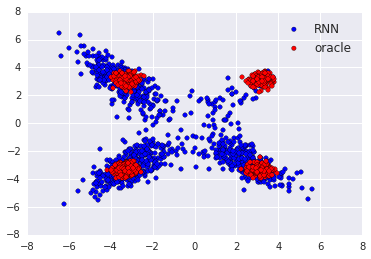

In [30]:
ss=styb_predlist[2]['relu']
plt.scatter(ss[0],ss[1],label='RNN')
ss=styb_predlist[2]['oracle']
plt.scatter(ss[0],ss[1],label='oracle',c='red')
plt.legend(loc='upper right',fontsize=12)

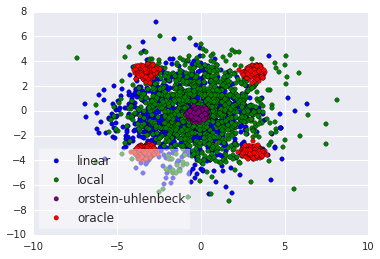

In [31]:
ss=styb_predlist[2]['linear']
plt.scatter(ss[0],ss[1],label='linear')
ss=styb_predlist[2]['local']
plt.scatter(ss[0],ss[1],label='local',c='green')
ss=styb_predlist[2]['orstein-uhlenbeck']
plt.scatter(ss[0],ss[1],label='orstein-uhlenbeck',c='purple')
ss=styb_predlist[2]['oracle']
plt.scatter(ss[0],ss[1],label='oracle',c='red')
leg = plt.legend(loc='lower left',fontsize=12, frameon=1)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.5)
plt.show()

In [33]:
rep_mat=[]
for rep in s_err_reps:
    for j in xrange(len(rep)):
        for name, pack in rep[j].iteritems():
            rep_mat.append([name, pack, dimseq[j]])
rep_mat=np.array(rep_mat)

In [34]:
rep_mat[rep_mat[:,0]=='relu',0]='RNN'

In [36]:
import pandas as pd
rep_pd_mat = pd.DataFrame({'dim':rep_mat[:,2].astype(np.float),'Method':rep_mat[:,0],'error':-1*rep_mat[:,1].astype(np.float)})

 None]

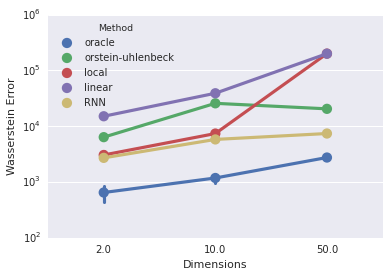

In [37]:
ax = sns.pointplot(data=rep_pd_mat, x="dim", y="error", hue="Method", n_boot=500)
ax.set(yscale='log',ylabel='Wasserstein Error',xlabel='Dimensions')

## Multimodal stuff

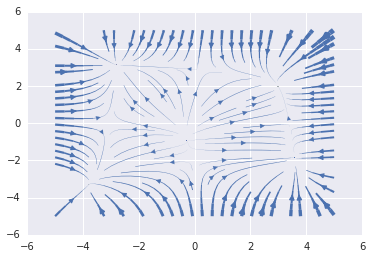

In [38]:
def himmelblau_flow(v):
    # himmelblau function: (x^2 +y - 11)^2 + (x+y^2-7)^2
    x = v[0,:]
    y = v[1,:]
    dx = 4*x*(-11+x**2+y)+2*(-7+x+y**2)
    dy = 2*(-11+x**2+y)+4*y*(-7+x+y**2)
    return -np.vstack((dx,dy))
plot_flow(x_test,y_test,himmelblau_flow)

In [39]:
np.random.seed(0)
h_init = np.random.normal(scale=0.5,size=(2,300))
h_out = euler_maruyama_dist(h_init,himmelblau_flow,0.01,1,2)